In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets.dataset import transform_dataset, kfold_dataset
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from R2Ntab import train as train, R2Ntab

In [2]:
# Read datasets
name = 'adult'
X, Y, X_headers, Y_headers = transform_dataset(name, method='onehot-compare', negations=False, labels='binary')
datasets = kfold_dataset(X, Y, shuffle=1)
X_train, X_test, Y_train, Y_test = datasets[0]
train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train.to_numpy()), torch.Tensor(Y_train))
test_set = torch.utils.data.TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(Y_test))

In [3]:
forest = GradientBoostingClassifier(n_estimators=50, random_state=0)
forest.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=50, random_state=0)

In [12]:
feature_weight = forest.feature_importances_
features = np.where(feature_weight == 0)[0]
print('Features removed using Gradient Boosting:', sorted(features))

Features removed using Gradient Boosting: [0, 6, 7, 8, 11, 14, 15, 16, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 38, 40, 50, 51, 52, 54, 55, 61, 63, 68, 69, 73, 74, 75, 76, 77, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 127]


In [5]:
net1 = R2Ntab(train_set[:][0].size(1), 50, 1)
with torch.no_grad():
    for feature in features:
        net1.cancelout_layer.weight[feature] = -1
    
acc1, rules1 = train(net1, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=0, epochs=1000, batch_size=400,
                     and_lam=1e-2, or_lam=1e-5, cancel_lam=1e-5, num_alter=500, track_performance=True)

Epoch: 100%|██████████| 1000/1000 [15:14<00:00,  1.09it/s, rules cancelled=71, loss=0.547, epoch accu=0.827, test accu=0.829, num rules=26, sparsity=0.913]


In [6]:
net2 = R2Ntab(train_set[:][0].size(1), 50, 1)
acc2, rules2 = train(net2, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=2e-3, epochs=1000, batch_size=400,
                     and_lam=1e-2, or_lam=1e-5, cancel_lam=1e-5, num_alter=500, track_performance=True)

Epoch: 100%|██████████| 1000/1000 [14:44<00:00,  1.13it/s, rules cancelled=79, loss=0.595, epoch accu=0.754, test accu=0.758, num rules=6, sparsity=0.952]


In [13]:
features = list(torch.where(net2.cancelout_layer.weight < 0)[0].numpy())
print('Features removed using R2NTab:', features)

Features removed using R2NTab: [0, 1, 2, 3, 6, 7, 8, 12, 13, 14, 15, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 62, 66, 67, 68, 69, 70, 71, 72, 73, 77, 78, 79, 81, 84, 85, 86, 90, 92, 94, 98, 99, 103, 109, 111, 112, 113, 114, 115, 117, 121, 124, 125, 126]


In [26]:
pca = PCA(n_components=1)
pca.fit(X_train)
component = pca.components_[0]
features = list(torch.where(torch.tensor(component) < 0)[0].numpy())
print('Features removed using PCA:', features)

Features removed using PCA: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 25, 26, 27, 28, 29, 31, 36, 38, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 53, 54, 58, 59, 60, 61, 64, 65, 68, 69, 70, 71, 73, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90, 92, 93, 94, 99, 100, 101, 102, 103, 107, 109, 111, 112, 113, 114, 115, 119, 123, 126]


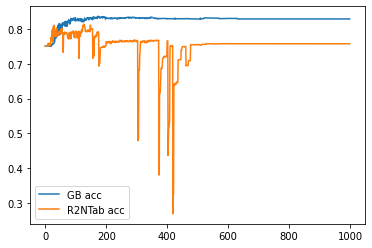

In [16]:
plt.plot(acc1)
plt.plot(acc2)
plt.legend(['GB acc', 'R2NTab acc'])
plt.show()

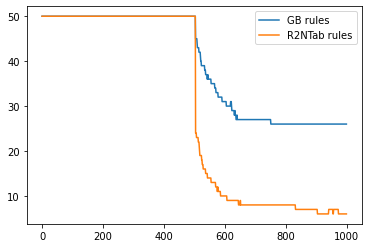

In [17]:
plt.plot(rules1)
plt.plot(rules2)
plt.legend(['GB rules', 'R2NTab rules'])
plt.show()